# Le but de ce fichier est d'étiqueter la base de donnees
*traitement des donnees*

In [34]:
import string

import pandas as pd
import matplotlib.pyplot as plt
import nltk
import csv
import numpy as np
from nltk.tokenize import word_tokenize
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer
import string
from textblob import TextBlob
import re
import spacy
import itertools

In [3]:
#importation des donnees brutes
base_donnees_L_link = "FR-L-MIGR-TWIT-2011-2022_meta.csv"
base_donnees_R_link = "Feuille 1-Instantané FR-R-MIGR-TWIT-2011-2022_meta.csv"
base_donnees_L = pd.read_csv(base_donnees_L_link)
base_donnees_R = pd.read_csv(base_donnees_R_link,delimiter=';')

In [4]:
#traitement de la base de donnees GAUCHE
base_donnees_L=base_donnees_L.dropna(subset=['data__id'])
base_donnees_L=base_donnees_L[base_donnees_L['data__id']!='data__id']
base_donnees_L = base_donnees_L.reset_index(drop=True)
base_donnees_L = base_donnees_L.drop_duplicates(subset=['data__id'])
base_donnees_L_formate = base_donnees_L[['data__id','data__text','data__created_at','author__username','data__author_id']]

In [5]:
#enregistrement des donnees formate au format csv
base_donnees_L_formate.to_csv('Data_Gauche_formaté')

In [6]:
#transformation des données L sous forme de dictionnaire
base_donnees_L_dict={}
for item, row in base_donnees_L_formate.iterrows():
    row_dict={'data__text':row['data__text'],'data__created_at':row['data__created_at'],'author__username':row['author__username'],'score':1}
    base_donnees_L_dict[row['data__id']]=row_dict

#transformation des données R sous forme de dictionnaire
base_donnees_R_dict={}
for item, row in base_donnees_R.iterrows():
    row_dict={'data__text':row['data__text'],'data__created_at':row['data__created_at'],'author__username':row['author__username'],'score':-1}
    base_donnees_R_dict[row['data__id']]=row_dict


In [7]:
#fusion des bases de données
base_donnees_dict = base_donnees_L_dict | base_donnees_R_dict
boucle_dict = base_donnees_dict.copy()
for tweet,value in boucle_dict.items():
    if not type(value['data__text']) == str:
        del base_donnees_dict[tweet]


*éttiquetage*

In [8]:
#on retire tous les url des tweets
url_pattern = r"(http?://[^\s]+)"
def remove_urls(text):
    matches = re.findall(url_pattern, text)
    return matches
def remove_urls_from_text(text):
    matches = remove_urls(text)
    for url in matches:
        text = text.replace(url, "")
    return text
def split_word(word):
    subwords = re.findall(r'\w+|\W+', word)
    return subwords

#on retire les URLS des tweets
for tweet in base_donnees_dict.keys():
    base_donnees_dict[tweet]['data__text']= remove_urls_from_text(base_donnees_dict[tweet]['data__text'])
for tweet in base_donnees_L_dict.keys():
    base_donnees_L_dict[tweet]['data__text']= remove_urls_from_text(base_donnees_L_dict[tweet]['data__text'])

#on tokenize et onracinise chaque tweet
stemmer =nltk.SnowballStemmer('french')
for tweet in base_donnees_dict.keys():
    tokens_tweet = []
    text = base_donnees_dict[tweet]['data__text']
    for n in range(len(nltk.word_tokenize(text))):

        word = nltk.word_tokenize(text)[n]
        if not word in string.punctuation:
            mot_propre = split_word(word)[0]
            mot_racine = stemmer.stem(mot_propre)
            tokens_tweet.append(mot_racine)
    base_donnees_dict[tweet]['vocabulaire']=tokens_tweet

for tweet in base_donnees_L_dict.keys():
    tokens_tweet = []
    text = base_donnees_L_dict[tweet]['data__text']
    for n in range(len(nltk.word_tokenize(text))):

        word = nltk.word_tokenize(text)[n]
        if not word in string.punctuation:
            mot_propre = split_word(word)[0]
            mot_racine = stemmer.stem(mot_propre)
            tokens_tweet.append(mot_racine)
    base_donnees_L_dict[tweet]['vocabulaire']=tokens_tweet


In [9]:
#création d'un sac de mot trié des mots vides pour chaque tweet
stop_words = set(nltk.corpus.stopwords.words("french"))
stop_words.update(['RT','#','\\n','@','’', "''",'``','','n','http','//','rt','a','»','«','...'])
for tweet in base_donnees_dict.keys():
    vocabulaire = base_donnees_dict[tweet]['vocabulaire']
    vocabulaire_trié =[]
    for mot in vocabulaire :
        if not mot.casefold() in stop_words:
            if not mot in string.punctuation:
                vocabulaire_trié.append(mot)
    base_donnees_dict[tweet]['vocabulaire_trié']=vocabulaire_trié

for tweet in base_donnees_L_dict.keys():
    vocabulaire = base_donnees_L_dict[tweet]['vocabulaire']
    vocabulaire_trié =[]
    for mot in vocabulaire :
        if not mot.casefold() in stop_words:
            if not mot in string.punctuation:
                vocabulaire_trié.append(mot)
    base_donnees_L_dict[tweet]['vocabulaire_trié']=vocabulaire_trié

In [10]:
#création d'un index inversé et d'un index inversé filtré
reversed_index={}

for tweet in base_donnees_dict.keys():
    for mot in base_donnees_dict[tweet]['vocabulaire_trié']:
        if not mot in reversed_index.keys():
            reversed_index[mot]={tweet:1}
        elif tweet not in reversed_index[mot].keys():
             reversed_index[mot][tweet]=1
        else:
            reversed_index[mot][tweet]+=1

reversed_index_L={}

for tweet in base_donnees_L_dict.keys():
    for mot in base_donnees_L_dict[tweet]['vocabulaire_trié']:
        if not mot in reversed_index_L.keys():
            reversed_index_L[mot]={tweet:1}
        elif tweet not in reversed_index_L[mot].keys():
             reversed_index_L[mot][tweet]=1
        else:
            reversed_index_L[mot][tweet]+=1

In [11]:
#analyse term frequency
dict_freq = {}
for mot in reversed_index:
    freq = 0
    for valeur in reversed_index[mot].values():
        freq += valeur
    dict_freq[mot]=freq

dict_freq_L={}
for mot in reversed_index_L:
    freq = 0
    for valeur in reversed_index_L[mot].values():
        freq += valeur
    dict_freq_L[mot]=freq


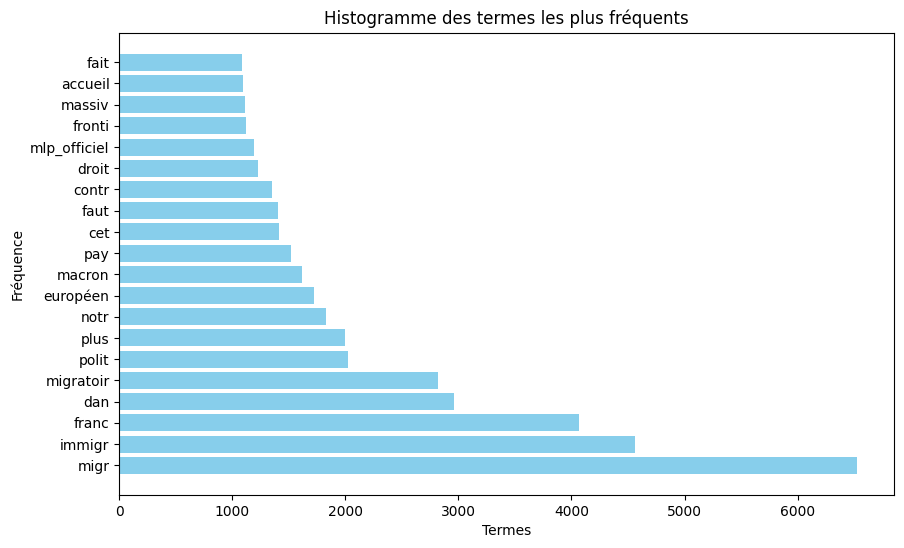

In [12]:
sorted_voc = dict(sorted(dict_freq.items(), key=lambda item: item[1], reverse=True))
sorted_voc_L = dict(sorted(dict_freq_L.items(), key=lambda item: item[1], reverse=True))
voc = list(sorted_voc.keys())[0:20]
freq = list(sorted_voc.values())[0:20]
plt.figure(figsize=(10, 6))
plt.barh(voc, freq, color='skyblue')
plt.xlabel('Termes')
plt.ylabel('Fréquence')
plt.title('Histogramme des termes les plus fréquents')
plt.show()

In [44]:
positive_word =[]
negative_word=[]
neutral_word=[]
for word,freq in sorted_voc.items():
    if freq >50:
        if word in sorted_voc_L.keys():
            if sorted_voc_L[word]/freq>0.6:
                positive_word.append(word)
            elif sorted_voc_L[word]/freq<0.1:
                negative_word.append(word)
            elif sorted_voc_L[word]/freq<0.55 and  sorted_voc_L[word]/freq>0.45:
                neutral_word.append(word)

In [45]:
negative_word

['mlp_officiel',
 'massiv',
 'clandestin',
 'j_bardel',
 'submers',
 'cnew',
 'peupl',
 'emmanuel',
 'terror',
 'contrôl',
 'mlp',
 'islam',
 'flux',
 'veulent',
 'illégal',
 'référendum',
 'mass',
 'communiqu',
 'fermet',
 '👉🏻',
 'milliard',
 'nation',
 'baiss',
 'insécur',
 'impos',
 'rnational_off',
 'délinqu',
 'laxism',
 'familial',
 'merkel',
 'communautar',
 'stopp',
 'lr',
 'sol',
 'f_philippot',
 'maîtris',
 'schengen',
 'chaos',
 'fraud',
 'mayott',
 'rétabl',
 'regroup',
 'pact',
 'union',
 'villag',
 'trafic',
 'impôt',
 'lesrepublicain',
 'fili',
 'européennes2019',
 'souverainet',
 'pomp',
 'explos',
 'matteosalvinim',
 'supplémentair',
 'laurentwauqu',
 'record',
 'hongr',
 'plenp',
 'bruxel',
 'concurrent',
 'dupontaignan',
 'argent',
 'irrespons',
 'wauqu',
 'chantag',
 'pactedemarrakech',
 'eciott',
 'dépens',
 'patriot',
 'agress',
 'foll',
 'hauss',
 'réduir',
 'entrer',
 'relocalis',
 'massif',
 'électeur',
 'fillon',
 'ggrmc',
 'échec',
 'vpecress',
 'pes',
 'supp

In [46]:
positive_word

['migrat',
 'paris',
 'réfugi',
 'solidar',
 'camp',
 'amp',
 'centr',
 'human',
 'associ',
 'eelv',
 'dign',
 'gen',
 'mair',
 'enfant',
 'emmanuelmacron',
 'anne_hidalgo',
 'jlmelenchon',
 'anti',
 'climat',
 'exil',
 'merc',
 'écolog',
 'humanitair',
 'travailleur',
 'indign',
 'condit',
 'del',
 'gt',
 'visit',
 'estherbenbass',
 'citoyen',
 'solidair',
 'gerardcollomb',
 'dversin',
 'loiasileimmigr',
 'hont',
 'mer',
 'extrêm',
 'sauv',
 '\u2066',
 '👉',
 'semain',
 'rétent',
 'manifest',
 'héberg',
 'collect',
 'yjadot',
 'collomb',
 'franceinsoumis',
 'tribun',
 'damiencarem',
 'mobilis',
 'publicsenat',
 'emmausolidarit',
 'journ',
 'chass',
 'lir',
 'ericcoquerel',
 'journal',
 'faureolivi',
 'chapel',
 'peur',
 'évacu',
 'them',
 'fratern',
 'administr',
 'accompagn',
 'capital',
 'combat',
 'inhumain',
 'senateurscrc',
 'pourunaccueildign',
 'benoithamon',
 'pr',
 'dignit',
 'circul',
 'cra',
 'disposit',
 'debatimmigr',
 'brnomorel',
 'fuient',
 'échang',
 'voic',
 'deputee_

In [47]:
neutral_word

['migr',
 'accueil',
 'asil',
 'loi',
 'débat',
 'caus',
 'humain',
 'jour',
 'dont',
 'soutien',
 'soir',
 'valeur',
 'femm',
 'libert',
 '3',
 'ru',
 'là',
 'urgenc',
 'comment',
 'polic',
 'charg',
 'fn',
 'just',
 'pauvr',
 'mieux',
 'jeun',
 'point',
 'plutôt',
 'princip',
 'milit',
 'danger',
 'posit',
 'scandal',
 'égal',
 'rencontr',
 'peu',
 'quoi',
 'répondr',
 'commenc',
 'bravo',
 'the',
 'jusqu',
 'suit',
 'gvt',
 'vidéo',
 'ensembl',
 '1er',
 'début',
 'mouv',
 'bel',
 'rejet',
 'particip',
 'monsieur',
 'parlementair',
 'pauvret',
 'enver',
 'oper',
 'interview',
 '12',
 'invit',
 'vivent',
 'histoir',
 'viv',
 'mission',
 '18',
 'violent',
 'initi',
 'oubli',
 'agit',
 'faudr',
 'nuit',
 'hauteur']

In [48]:
#on crée un score pour étiquetter chaque tweet:
def label_text(text, negative_word, neutral_word, positive_word):
    negative_score = sum(word in text for word in negative_word)
    neutral_score = sum(word in text for word in neutral_word)
    positive_score = sum(word in text for word in positive_word)
    return [negative_score,neutral_score,positive_score]

def score(text,negative_word,neutral_word,positive_word):
    [negative,neutral,positive]=label_text(text,negative_word,neutral_word,positive_word)
    if negative+positive+neutral != 0:
        score=(positive-negative)/(negative+positive+neutral)
        if score < -0.3:
            score = -1
        elif score>0.3:
            score = 1
        else :
            score = 0
    else:
        score=0
    return score

base_donnees_dict_etiquette = base_donnees_dict.copy()
for tweet in base_donnees_dict_etiquette.keys():
    base_donnees_dict_etiquette[tweet]['score']=score(base_donnees_dict_etiquette[tweet]['vocabulaire_trié'],negative_word,neutral_word,positive_word)



In [49]:
neutral_tweet = 0
positive_tweet = 0
negative_tweet = 0
for tweet in base_donnees_dict_etiquette.keys():
    if base_donnees_dict_etiquette[tweet]['score']==0:
        neutral_tweet+=1
    elif base_donnees_dict_etiquette[tweet]['score']==1:
        positive_tweet+=1
    else:
        negative_tweet+=1

In [50]:
print('le nombre de tweet neutre est : {}'.format(neutral_tweet))
print('le nombre de tweet positif est : {}'.format(positive_tweet))
print('le nombre de tweet negatif est : {}'.format(negative_tweet))
print('le nombre de tweet total est : {}'.format(neutral_tweet+positive_tweet+negative_tweet))

le nombre de tweet neutre est : 4670
le nombre de tweet positif est : 4327
le nombre de tweet negatif est : 8072
le nombre de tweet total est : 17069


In [52]:
for tweet_id, tweet in itertools.islice(base_donnees_dict_etiquette.items(), 50):
    print(tweet['data__text'])
    print(tweet['score'])

RT @LutteOuvriere: #Migrants, #chômage, #police : une société en crise, malade du capitalisme \n L'édito ⬇️ \n https://t.co/sxkwJdMZXX
1
Concours de démagogie autour des #migrants de #Calais ⬇️ https://t.co/RObSQv7ohh
0
Accueillons les #migrants et intégrons-les dans nos combats pour changer ce monde de plus en plus inhumain. \n #LT
1
#migrants : Affirmons pour tous les exploités de cette terre la liberté de circulation et d’installation \n #LT
1
Les principaux candidats de gauche et de droite ont choisi de faire du terrorisme et des migrants le centre de la campagne \n #LT
0
RT @FrancebleuParis: #VIDEO : @n_arthaud (LO) était sur France Bleu.Elle a  parlé de la #Presidentielle2017, #emploi, #migrants .  https://t.co/Sy580Ep8lQ https://t.co/TzEfnxPZdU
0
Le chômage dure depuis des décennies, pas lié aux #migrants : ne nous battons pas entre pauvres, revendiquons les richesses de cette société
0
La politique du gouvernement envers les #migrants est criminelle est honteuse : \n barbelés, 

In [58]:
#fin de ce notebook on exporte la base de  données ettiqueté dans un fichier CSV pour faciliter la transmission des données
filename = 'base_donnees_etiquette.csv'
with open(filename, mode='w', newline='', encoding='utf-8') as file:
    fieldnames = ['id'] + list(next(iter(base_donnees_dict_etiquette.values())).keys())
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    for key, value in base_donnees_dict_etiquette.items():
        row = {'id': key}
        row.update(value)
        writer.writerow(row)

#on exporte l'index inversé
filename='inverted_index.csv'
with open(filename, mode='w', newline='', encoding='utf-8') as file:
    fieldnames = ['word', 'tweet_id', 'frequency']
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    for word, tweets in reversed_index.items():
        for tweet_id, frequency in tweets.items():
            writer.writerow({'word': word, 'tweet_id': tweet_id, 'frequency': frequency})

In [55]:
#procédure de reconstruction du dictionnaire à partir du csv de la base de données
filename = 'base_donnees_etiquette.csv'
base_donnees_etiquete = {}
with open(filename, mode='r', newline='', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    for row in reader:
        key = row['id']
        del row['id']
        base_donnees_etiquete[key] = row

#procédure de reconstruction du dictionnaire à partir du csv de l'index inversé
filename='inverted_index.csv'
inverted_index = {}
with open(filename, mode='r', newline='', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    for row in reader:
        word = row['word']
        tweet_id = int(row['tweet_id'])
        frequency = int(row['frequency'])
        if word not in inverted_index:
            inverted_index[word] = {}
        inverted_index[word][tweet_id] = frequency